notes:

dropping type (could be related to previous transactions) \
amount == 0 is fraud \
destination type = M is not fraud

In [72]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support as prfs
from sklearn.metrics import plot_confusion_matrix, confusion_matrix, fbeta_score
from imblearn.over_sampling import SMOTE 
from sklearn.preprocessing import StandardScaler

In [2]:
df = pd.read_csv('transactions.csv')

In [3]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrig,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0


## 1 Exploratory Data Analysis

### 1.1 Nulls

In [4]:
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrig    0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
dtype: int64

### 1.2 Class Balance

In [52]:
(df['isFraud'].value_counts() / df['isFraud'].value_counts().sum()).apply(lambda x: f'{x*100:.2f}%')

0    99.88%
1     0.12%
Name: isFraud, dtype: object

Note: Extremely imbalanced dataset

### 1.3 Origin

In [5]:
df.groupby(df['nameOrig'].str[0])['isFraud'].agg(['size', 'mean', 'sum'])

,size,mean,sum
nameOrig,,,
C,6351193,0.001215,7717


In [8]:
df['nameOrig'].value_counts()

C1902386530    3
C545315117     3
C1462946854    3
C724452879     3
C1832548028    3
              ..
C504507899     1
C1528685587    1
C1533690590    1
C201911358     1
C1919080261    1
Name: nameOrig, Length: 6341907, dtype: int64

Note: Origins are all customers, customers only transact outwards 0-3x

### 1.4 Destination

In [6]:
df.groupby(df['nameDest'].str[0])['isFraud'].agg(['size', 'mean', 'sum'])

,size,mean,sum
nameDest,,,
C,4203361,0.001836,7717
M,2147832,0.000000,0


Note: All merchant transactions are not frauds

#### 1.4.1 Destination Transaction Count vs Fraud Count

Text(0, 0.5, 'Fraud Count')

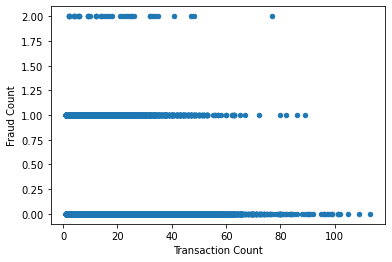

In [40]:
df['nameDest'].value_counts().to_frame().join(df.groupby('nameDest')['isFraud'].sum()).plot.scatter(x='nameDest', y='isFraud')
plt.xlabel('Transaction Count')
plt.ylabel("Fraud Count")

Note: wanted to check whether destinations with higher transaction counts had higher frauds, findings inconclusive

In [57]:
df = df[df['nameDest'].str[0] == 'C']

In [58]:
df.shape

(4203361, 10)

### 1.5 Step

<AxesSubplot:>

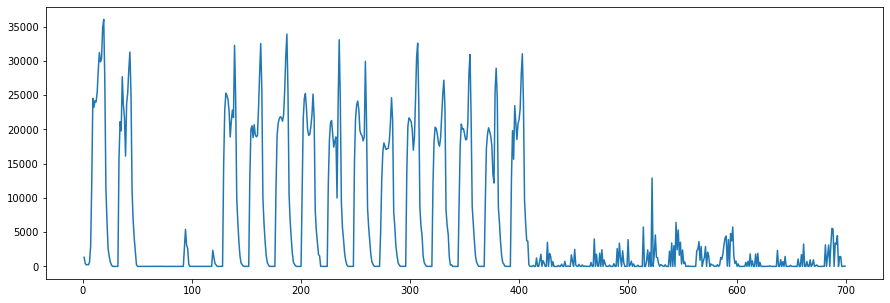

In [59]:
df['step'].value_counts().sort_index().plot(figsize=(15,5))

#### 1.5.1 Feature Engineering: Day Step and Hour of Day

In [60]:
df['day'] = df['step'].apply(lambda x: x // 24)
df['hour'] = df['step'].apply(lambda x: x % 24)

<ipython-input-60-a2c1dd79376d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['day'] = df['step'].apply(lambda x: x // 24)
<ipython-input-60-a2c1dd79376d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hour'] = df['step'].apply(lambda x: x % 24)


<AxesSubplot:>

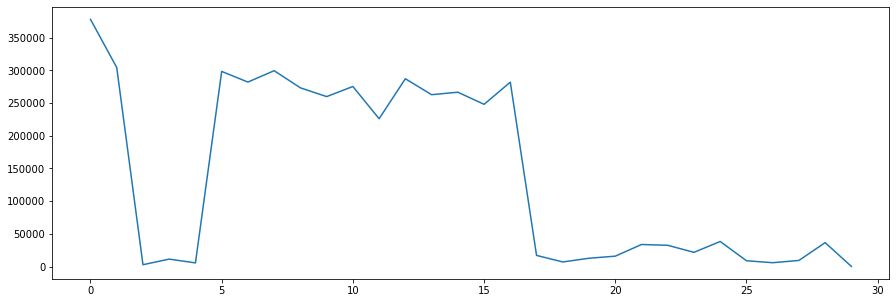

In [61]:
df['day'].value_counts().sort_index().plot(figsize=(15,5))

<AxesSubplot:>

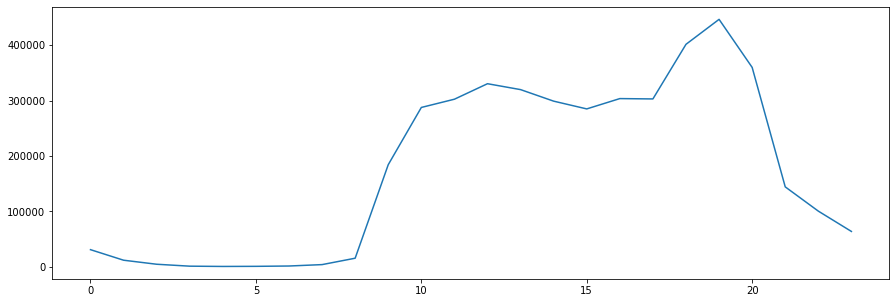

In [62]:
df['hour'].value_counts().sort_index().plot(figsize=(15,5))

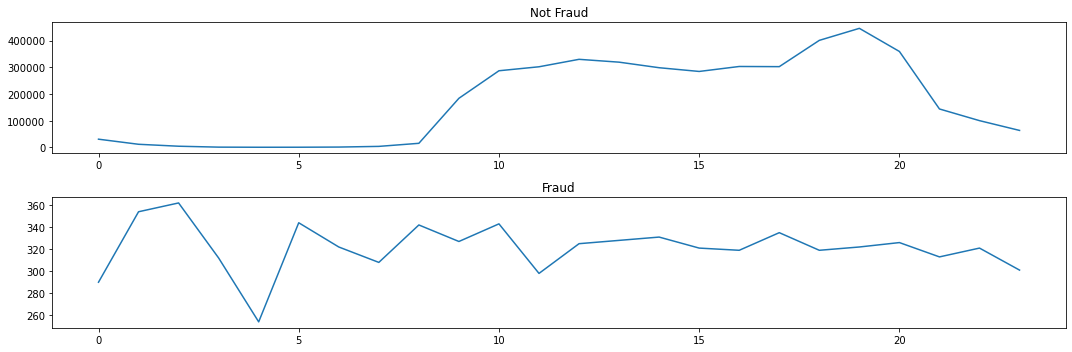

In [63]:
fig, ax = plt.subplots(2,1,figsize=(15,8))
df.loc[df['isFraud'] == 0, 'hour'].value_counts().sort_index().plot(figsize=(15,5), ax=ax[0])
ax[0].set_title('Not Fraud')
df.loc[df['isFraud'] == 1, 'hour'].value_counts().sort_index().plot(figsize=(15,5), ax=ax[1])
ax[1].set_title('Fraud')
plt.tight_layout()

Note: Difference in transaction behavior (fraud and not fraud) in terms of hour of day

### 1.6 Transaction Type

In [64]:
df.loc[df['isFraud'] == 0, 'type'].value_counts()

CASH_OUT    2229501
CASH_IN     1396865
TRANSFER     527968
DEBIT         41310
Name: type, dtype: int64

In [65]:
df.loc[df['isFraud'] == 1, 'type'].value_counts()

CASH_OUT    3868
TRANSFER    3849
Name: type, dtype: int64

In [66]:
df.shape

(4203361, 12)

In [67]:
df = df.loc[df['type'].apply(lambda x: x in ['CASH_OUT', 'TRANSFER'])]

In [68]:
df.shape

(2765186, 12)

Note: Fraudulent Transactions only occur in `CASH_OUT` and `TRANSFER` types

### 1.7 Transaction Amount

Text(0.5, 1.0, 'TRANSFER')

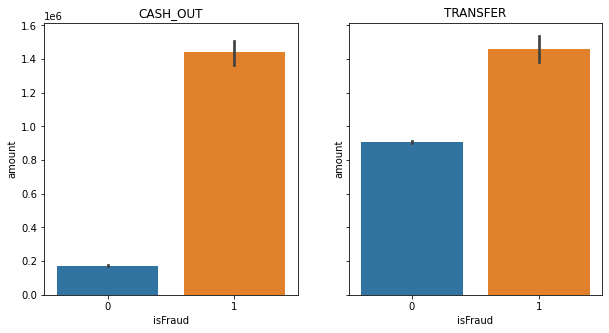

In [69]:
fig, ax = plt.subplots(1, 2, sharey=True, figsize=(10,5))
sns.barplot(data=df[df['type'] == 'CASH_OUT'], y='amount', x='isFraud', ax=ax[0])
ax[0].set_title('CASH_OUT')
sns.barplot(data=df[df['type'] == 'TRANSFER'], y='amount', x='isFraud', ax=ax[1])
ax[1].set_title('TRANSFER')

In [70]:
df[df['isFraud'] == 1].sort_values('amount').head(20)

,step,type,amount,nameOrig,oldbalanceOrig,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,day,hour
2736447,212,CASH_OUT,0.00,C1510987794,0.00,0.0,C1696624817,0.00,0.00,1,8,20
6205440,586,CASH_OUT,0.00,C1303719003,0.00,0.0,C900608348,1328472.86,1328472.86,1,24,10
6266414,617,CASH_OUT,0.00,C1971175979,0.00,0.0,C1352345416,0.00,0.00,1,25,17
5996410,425,CASH_OUT,0.00,C69493310,0.00,0.0,C719711728,2921531.34,2921531.34,1,17,17
5996408,425,CASH_OUT,0.00,C832555372,0.00,0.0,C1462759334,76759.90,76759.90,1,17,17
5563714,387,CASH_OUT,0.00,C1294472700,0.00,0.0,C1325541393,7970766.57,7970766.57,1,16,3
6281483,646,CASH_OUT,0.00,C2060908932,0.00,0.0,C1587892888,0.00,0.00,1,26,22
6281485,646,CASH_OUT,0.00,C1997645312,0.00,0.0,C601248796,0.00,0.00,1,26,22
6168500,554,CASH_OUT,0.00,C10965156,0.00,0.0,C1493336195,230289.66,230289.66,1,23,2
3247298,250,CASH_OUT,0.00,C521393327,0.00,0.0,C480398193,0.00,0.00,1,10,10


In [71]:
df.loc[df['amount'] == 0, 'isFraud']

2736447    1
3247298    1
3760289    1
5563714    1
5996408    1
5996410    1
6168500    1
6205440    1
6266414    1
6281483    1
6281485    1
6296015    1
Name: isFraud, dtype: int64

In [14]:
df = df[df['amount'] > 0]
df.shape

(2765174, 10)

Note: All 0 amount transactions are Fraud, Frauds tend to have higher amounts

### 1.8 Balance

#### 1.8.1 Cash Out Type

In [81]:
temp = df[df['type'] == 'CASH_OUT']
temp['diff_orig'] = temp['oldbalanceOrig'] - temp['newbalanceOrig']
temp['diff_dest'] = temp['oldbalanceDest'] - temp['newbalanceDest']
temp[['diff_orig', 'diff_dest', 'amount', 'isFraud']]

<ipython-input-81-563a187a260b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['diff_orig'] = temp['oldbalanceOrig'] - temp['newbalanceOrig']
<ipython-input-81-563a187a260b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['diff_dest'] = temp['oldbalanceDest'] - temp['newbalanceDest']


,diff_orig,diff_dest,amount,isFraud
3,181.00,21182.00,181.00,1
15,15325.00,-46430.44,229133.94,0
42,26845.41,286384.84,110414.71,0
47,1942.02,6146.82,56953.90,0
48,0.00,-5800793.91,5346.89,0
...,...,...,...,...
6351165,0.00,-214607.78,214607.78,0
6351183,215013.30,-215013.30,215013.30,1
6351186,62372.43,-62372.43,62372.43,1
6351189,162326.52,-162326.52,162326.52,1


In [82]:
temp['test1'] = (temp['diff_orig'] == -temp['diff_dest'])
temp.groupby(['test1', 'isFraud']).size()

<ipython-input-82-bf95bef3096c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['test1'] = (temp['diff_orig'] == -temp['diff_dest'])


test1  isFraud
False  0          2163340
       1             1850
True   0            66161
       1             2018
dtype: int64

In [83]:
temp['test2'] = (temp['diff_orig'] == -temp['amount'])
temp.groupby(['test2', 'isFraud']).size()

<ipython-input-83-065a2afd0c82>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['test2'] = (temp['diff_orig'] == -temp['amount'])


test2  isFraud
False  0          2229501
       1             3856
True   1               12
dtype: int64

Note: Fraudulent Cash Out Transactions always have the amount equalling the difference between the origin's new and old balance

#### 1.8.2 Transfer Type

In [72]:
temp = df[df['type'] == 'TRANSFER']
temp['diff_orig'] = temp['oldbalanceOrig'] - temp['newbalanceOrig']
temp['diff_dest'] = temp['oldbalanceDest'] - temp['newbalanceDest']
temp[['diff_orig', 'diff_dest', 'amount', 'isFraud']]

<ipython-input-72-71e9f293a1cf>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['diff_orig'] = temp['oldbalanceOrig'] - temp['newbalanceOrig']
<ipython-input-72-71e9f293a1cf>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['diff_dest'] = temp['oldbalanceDest'] - temp['newbalanceDest']


,diff_orig,diff_dest,amount,isFraud
2,181.00,0.00,181.00,1
19,705.00,22425.00,215310.30,0
24,10835.00,-2712905.89,311685.89,0
58,62610.80,-7866.29,62610.80,0
78,10363.39,33857.48,42712.39,0
...,...,...,...,...
6351181,0.00,-125500.54,125500.53,0
6351182,215013.30,0.00,215013.30,1
6351185,62372.43,0.00,62372.43,1
6351188,162326.52,0.00,162326.52,1


In [80]:
temp['comparison'] = (temp['diff_orig'] == temp['amount']) * 1
temp.groupby(['isFraud', 'comparison']).size()

<ipython-input-80-0ee3c72e22b7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['comparison'] = (temp['diff_orig'] == temp['amount']) * 1


isFraud  comparison
0        0             516849
         1              11119
1        0                 38
         1               3811
dtype: int64

Note: For `TRANSFER` types, fraudulent transactions almost always have amounts equalling that of the difference between the origin's new and old balance.

#### 1.8.3 orig Balance

(0.0, 4000000.0)

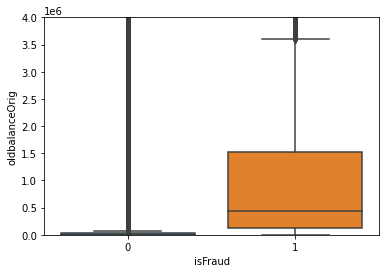

In [202]:
sns.boxplot(data=df, x='isFraud', y='oldbalanceOrig')
plt.ylim(0,0.4*1e7)

Note: Higher Origin Balance means higher Fraud chance

#### 1.8.4 dest Balance

(0.0, 5000000.0)

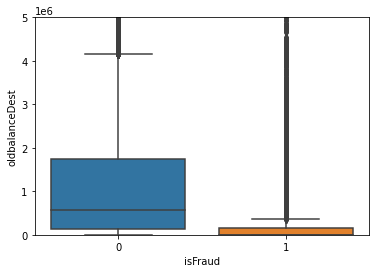

In [208]:
sns.boxplot(data=df, x='isFraud', y='oldbalanceDest')
plt.ylim(0,0.5*1e7)

Note: Lower Destination Balance means higher Fraud chance

#### 1.8.5 Differences

(0.0, 4000000.0)

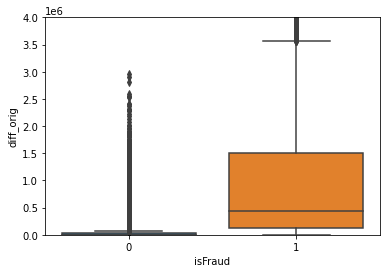

In [206]:
temp = df.copy()
temp['diff_orig'] = temp['oldbalanceOrig'] - temp['newbalanceOrig']
temp['diff_dest'] = temp['oldbalanceDest'] - temp['newbalanceDest']
sns.boxplot(data=temp, x='isFraud', y='diff_orig')
plt.ylim(0,0.4*1e7)

(0.0, -2000000.0)

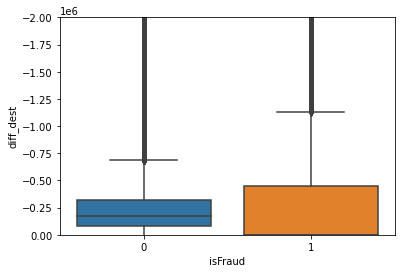

In [212]:
temp = df.copy()
temp['diff_orig'] = temp['oldbalanceOrig'] - temp['newbalanceOrig']
temp['diff_dest'] = temp['oldbalanceDest'] - temp['newbalanceDest']
sns.boxplot(data=temp, x='isFraud', y='diff_dest')
plt.ylim(0,-0.2*1e7)

### 1.9 Repeat transactions per destination

#### 1.9.1 by Step

In [84]:
step_fraud_cnt = df.groupby(['step', 'nameDest'])['isFraud'].agg(['size', 'mean', 'sum'])
step_fraud_cnt

size  mean  sum
step nameDest                    
1    C100555887      1   0.0    0
     C1007251739     1   1.0    1
     C1018298342     1   0.0    0
     C1023714065    11   0.0    0
     C1032986144     1   0.0    0
...                ...   ...  ...
699  C804640291      1   0.0    0
     C844456949      1   0.0    0
     C86170378       1   0.0    0
     C875581231      1   0.0    0
     C901371341      1   0.0    0

[2605286 rows x 3 columns]

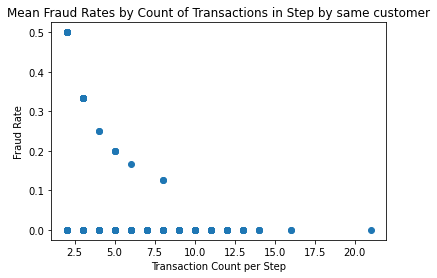

In [85]:
plt.scatter(x='size', y='mean', data=step_fraud_cnt[step_fraud_cnt['size'] > 1])
plt.title('Mean Fraud Rates by Count of Transactions in Step by same customer')
plt.xlabel('Transaction Count per Step')
plt.ylabel('Fraud Rate');

Text(0.5, 1.0, 'Sum of Fraud Rates by Count of Transactions per destination per Step')

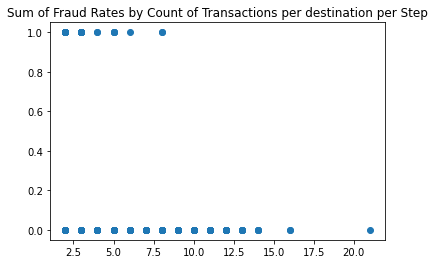

In [86]:
plt.scatter(x='size', y='sum', data=step_fraud_cnt[step_fraud_cnt['size'] > 1])
plt.title('Sum of Fraud Rates by Count of Transactions per destination per Step')

Note: Multiple transactions in the same time step are unlikely to have fraudulent transactions

#### 1.9.2 by day

Text(0.5, 1.0, 'Fraud counts by count of transactions per destination per day')

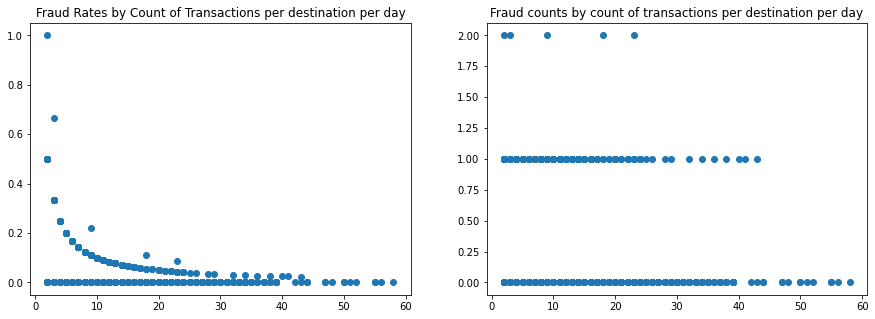

In [87]:
day_fr = df.groupby(['day', 'nameDest'])['isFraud'].agg(['size', 'mean', 'sum'])

fig, ax = plt.subplots(1,2,figsize=(15,5))
ax[0].scatter(x='size', y='mean', data=day_fr[day_fr['size'] > 1])
ax[0].set_title('Fraud Rates by Count of Transactions per destination per day')
ax[1].scatter(x='size', y='sum', data=day_fr[day_fr['size'] > 1])
ax[1].set_title('Fraud counts by count of transactions per destination per day')

Note: Multiple transactions in the same day are unlikely to be fraudulent transactions

In [85]:
df['nameDest'].value_counts()

C1286084959    75
C1360767589    68
C665576141     68
C97730845      67
C248609774     64
               ..
C150924502      1
C1046106474     1
C1148927648     1
C990646802      1
C465069338      1
Name: nameDest, Length: 507777, dtype: int64

### 1.10 Succesive Transactions

"Given the nature of the data, your REST API will likely need to take into account
previous transactions, so make sure it is able to take note of transactions from
your training dataset as well as previous API calls."

In [106]:
# df = pd.read_csv('transactions.csv')
# df.shape

#### 1.10.1 Same origin, destination, amount, step

In [107]:
df.groupby(['step', 'nameOrig', 'nameDest', 'amount']).size().sort_values(ascending=False)

step  nameOrig     nameDest     amount   
1     C10001825    C1850180796  2655.04      1
306   C1634196480  C1510925476  263122.52    1
      C1633371116  C977657392   448985.96    1
      C1633165296  C2056190450  163686.06    1
      C1633159220  M106584622   3461.30      1
                                            ..
183   C1851444164  C101666128   122954.32    1
      C1851428819  M2102352167  10560.40     1
      C1851421867  C24769777    29387.65     1
      C1851414444  C1472638331  315265.03    1
699   C977451723   C1734283234  214607.78    1
Length: 6351193, dtype: int64

Note: There are no instances of successive transactions involving the same origin, destination, amount and step

#### 1.10.2 Same origin, destination, step

In [108]:
df.groupby(['step', 'nameOrig', 'nameDest']).size().sort_values(ascending=False)

step  nameOrig     nameDest   
1     C10001825    C1850180796    1
306   C1634196480  C1510925476    1
      C1633371116  C977657392     1
      C1633165296  C2056190450    1
      C1633159220  M106584622     1
                                 ..
183   C1851444164  C101666128     1
      C1851428819  M2102352167    1
      C1851421867  C24769777      1
      C1851414444  C1472638331    1
699   C977451723   C1734283234    1
Length: 6351193, dtype: int64

Note: There are no instances of successive transactions involving the same origin, destination, and step

#### 1.10.3 Same origin, and step

In [113]:
temp = df.groupby(['step', 'nameOrig'])['isFraud'].agg(['size', 'sum']).sort_values('size', ascending=False)
temp[temp['size'] > 1]

,,size,sum
step,nameOrig,,
160,C407378873,2,0
15,C1386878398,2,0
229,C1044884182,2,0
322,C2084454803,2,0
402,C1061931265,2,0
212,C837940818,2,0
17,C133857826,2,0
180,C1584515358,2,0
209,C1530288976,2,0


Note: Instances of successive transactions involving the same origin, and step produce no fraudulent transactions

#### 1.10.4 Same destination and step

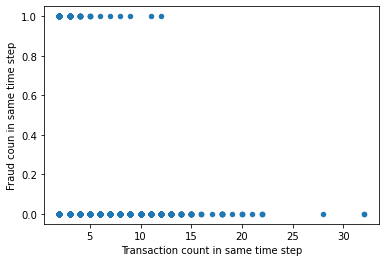

In [116]:
temp = df.groupby(['step', 'nameDest'])['isFraud'].agg(['size', 'sum']).sort_values('size', ascending=False)
temp[temp['size'] > 1].plot.scatter(x='size', y='sum')
plt.xlabel('Transaction count in same time step')
plt.ylabel('Fraud coun in same time step');

In [150]:
temp = df.copy()
temp['succession'] = temp.groupby(['step', 'nameDest']).cumcount() + 1
temp['succession'].value_counts()

1     2605274
2      130545
3       19253
4        5713
5        2230
6        1060
7         529
8         275
9         133
10         76
11         32
12         23
13         13
14          7
15          3
16          3
17          1
18          1
19          1
20          1
21          1
Name: succession, dtype: int64

In [151]:
temp.groupby('succession')['isFraud'].mean()

succession
1     0.002938
2     0.000314
3     0.000208
4     0.000525
5     0.000448
6     0.001887
7     0.000000
8     0.000000
9     0.000000
10    0.000000
11    0.000000
12    0.000000
13    0.000000
14    0.000000
15    0.000000
16    0.000000
17    0.000000
18    0.000000
19    0.000000
20    0.000000
21    0.000000
Name: isFraud, dtype: float64

Note: Later transactions in a succession appear to less likely be fraudulent

## 2 Predictions

### 2.1 Load Data

In [260]:
df = pd.read_csv('transactions.csv')
df.shape

(6351193, 10)

In [261]:
df['isFraud'].value_counts()

0    6343476
1       7717
Name: isFraud, dtype: int64

In [262]:
(df['isFraud'].value_counts() / df['isFraud'].value_counts().sum()).apply(lambda x: f'{x*100:.2f}%')

0    99.88%
1     0.12%
Name: isFraud, dtype: object

### 2.2 Feature Engineering

#### 2.2.1 Successive transactions (same destination and same step)

In [263]:
df['succession'] = df.groupby(['step', 'nameDest']).cumcount() + 1

#### 2.2.2 Origin Balance Difference and Comparisons

In [264]:
df['diffOrig'] = df['newbalanceOrig'] - df['oldbalanceOrig']
df['diffDest'] = df['newbalanceDest'] - df['oldbalanceDest']

df['OrigDest_flag'] = (df['diffOrig'] == -df['diffDest']) * 1
df['OrigAmt_flag'] = (df['diffOrig'] == -df['amount']) * 1
df['DestAmt_flag'] = (df['diffDest'] == df['amount']) * 1

### 2.3 Rule-Based Algorithm

#### 2.3.1 Merchant Destinations are considered not Fraudulent

In [186]:
df = df[df['nameDest'].str[0] != 'M']
df.shape

(4203361, 16)

#### 2.3.2 Only `CASH_OUT` and `TRANSFER` types can be Fraudulent

In [187]:
df = df.loc[df['type'].apply(lambda x: x in ['CASH_OUT', 'TRANSFER'])]
df.shape

(2765186, 16)

#### 2.3.3 Transaction Amounts equal to 0 are all Fraudulent

In [188]:
df = df[df['amount'] > 0]
df.shape

(2765174, 16)

### 2.4 Class Balance

In [189]:
df['isFraud'].value_counts()

0    2757469
1       7705
Name: isFraud, dtype: int64

In [190]:
(df['isFraud'].value_counts() / df['isFraud'].value_counts().sum()).apply(lambda x: f'{x*100:.2f}%')

0    99.72%
1     0.28%
Name: isFraud, dtype: object

In [191]:
df

,step,type,amount,nameOrig,oldbalanceOrig,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,succession,diffOrig,diffDest,OrigDest_flag,OrigAmt_flag,DestAmt_flag
2,1,TRANSFER,181.00,C1305486145,181.00,0.0,C553264065,0.00,0.00,1,1,-181.00,0.00,0,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.0,C38997010,21182.00,0.00,1,1,-181.00,-21182.00,0,1,0
15,1,CASH_OUT,229133.94,C905080434,15325.00,0.0,C476402209,5083.00,51513.44,0,1,-15325.00,46430.44,0,0,0
19,1,TRANSFER,215310.30,C1670993182,705.00,0.0,C1100439041,22425.00,0.00,0,1,-705.00,-22425.00,0,0,0
24,1,TRANSFER,311685.89,C1984094095,10835.00,0.0,C932583850,6267.00,2719172.89,0,1,-10835.00,2712905.89,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6351186,699,CASH_OUT,62372.43,C1915659563,62372.43,0.0,C421781202,1195387.47,1257759.90,1,1,-62372.43,62372.43,0,1,0
6351188,699,TRANSFER,162326.52,C1557504343,162326.52,0.0,C404511346,0.00,0.00,1,1,-162326.52,0.00,0,1,0
6351189,699,CASH_OUT,162326.52,C1532317723,162326.52,0.0,C446134087,0.00,162326.52,1,1,-162326.52,162326.52,1,1,1
6351190,699,TRANSFER,2763398.31,C577803442,2763398.31,0.0,C619602282,0.00,0.00,1,1,-2763398.31,0.00,0,1,0


### 2.5 Data Processing

In [213]:
features = (pd.get_dummies(df, columns=['type'],
                           drop_first=True)
            .drop(columns=['step', 'nameOrig', 'nameDest', 'isFraud',
                           'newbalanceOrig', 'newbalanceDest'])
            .rename(columns={'type_TRANSFER': 'Transfer'}))
features

,amount,oldbalanceOrig,oldbalanceDest,succession,diffOrig,diffDest,OrigDest_flag,OrigAmt_flag,DestAmt_flag,Transfer
2,181.00,181.00,0.00,1,-181.00,0.00,0,1,0,1
3,181.00,181.00,21182.00,1,-181.00,-21182.00,0,1,0,0
15,229133.94,15325.00,5083.00,1,-15325.00,46430.44,0,0,0,0
19,215310.30,705.00,22425.00,1,-705.00,-22425.00,0,0,0,1
24,311685.89,10835.00,6267.00,1,-10835.00,2712905.89,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...
6351186,62372.43,62372.43,1195387.47,1,-62372.43,62372.43,0,1,0,0
6351188,162326.52,162326.52,0.00,1,-162326.52,0.00,0,1,0,1
6351189,162326.52,162326.52,0.00,1,-162326.52,162326.52,1,1,1,0
6351190,2763398.31,2763398.31,0.00,1,-2763398.31,0.00,0,1,0,1


In [214]:
target = df['isFraud']
target

2          1
3          1
15         0
19         0
24         0
          ..
6351186    1
6351188    1
6351189    1
6351190    1
6351191    1
Name: isFraud, Length: 2765174, dtype: int64

### 2.6 Validation Split

In [216]:
xtr, xte, ytr, yte = train_test_split(features.to_numpy(),
                                      target.to_numpy(),
                                      stratify=target.to_numpy())

### 2.7 Training

In [225]:
rfc = RandomForestClassifier(n_jobs=-1)
rfc.fit(xtr,ytr)

RandomForestClassifier(n_jobs=-1)

In [226]:
rfc.score(xte,yte)

0.9994315009243535

In [232]:
pd.DataFrame(prfs(yte, rfc.predict(xte)),
             columns=['Not Fraud', 'Fraud'],
             index=['Precision', 'Recall', 'F1', 'Size'])

,Not Fraud,Fraud
Precision,0.999514,0.964827
Recall,0.999916,0.826064
F1,0.999715,0.890070
Size,689368.000000,1926.000000


Note: The accuracy mentioned above only focuses on the ML part and not the rule-based part of the algorithm. For computational efficiency purposes, Random Forest was arbitrarily chosen as the algorithm. Because of this, no feature scaling was needed.

#### 2.7.1 SMOTE

In [243]:
sm = SMOTE()
xtr_sm, ytr_sm = sm.fit_resample(xtr, ytr)

In [244]:
rfc = RandomForestClassifier(n_jobs=-1)
rfc.fit(xtr_sm,ytr_sm)

RandomForestClassifier(n_jobs=-1)

In [245]:
pd.DataFrame(prfs(yte, rfc.predict(xte)),
             columns=['Not Fraud', 'Fraud'],
             index=['Precision', 'Recall', 'F1', 'Size'])

,Not Fraud,Fraud
Precision,0.999909,0.774314
Recall,0.999212,0.967290
F1,0.999560,0.860111
Size,689368.000000,1926.000000


Note: The accuracy mentioned above only focuses on the ML part and not the rule-based part of the algorithm. In the case of Fraud Detection, recall is arguably more important than precision so in this scenario, SMOTE is effective.

### 2.8 Model Selection and Hyper Parameter Tuning

Because of computational constraints, this section was not pursued.

### 2.9 Overall Accuracy Calculation - Rule-based + ML

In [2]:
df = pd.read_csv('transactions.csv')

#### 2.9.1 Feature Engineering

In [4]:
df['diffOrig'] = df['newbalanceOrig'] - df['oldbalanceOrig']
df['diffDest'] = df['newbalanceDest'] - df['oldbalanceDest']
df['succession'] = df.groupby(['step', 'nameDest']).cumcount() + 1
df['OrigDest_flag'] = (df['diffOrig'] == -df['diffDest']) * 1
df['OrigAmt_flag'] = (df['diffOrig'] == -df['amount']) * 1
df['DestAmt_flag'] = (df['diffDest'] == df['amount']) * 1

#### 2.9.2 Split before applying rule based algorithm

In [5]:
def xysplit(dfsplit):
    features = (pd.get_dummies(dfsplit, columns=['type'],
                               drop_first=True)
                .drop(columns=['step', 'nameOrig', 'nameDest',
                               'newbalanceOrig', 'newbalanceDest'])
                .rename(columns={'type_TRANSFER': 'Transfer'}))
    target = dfsplit['isFraud']
    return features, target

In [51]:
train, test = train_test_split(df, stratify=df['isFraud'].to_numpy(), random_state=0)

#### 2.9.3 Training Data Processing

**Rule-based filtering**

In [52]:
train = train[train['nameDest'].str[0] != 'M']
train = train.loc[train['type'].isin(['CASH_OUT', 'TRANSFER'])]
train = train[train['amount'] > 0]

**XY split**

In [55]:
def xysplit(dfsplit):
    features = (pd.get_dummies(dfsplit, columns=['type'],
                               drop_first=True)
                .drop(columns=['step', 'nameOrig', 'nameDest', 'isFraud',
                               'newbalanceOrig', 'newbalanceDest'])
                .rename(columns={'type_TRANSFER': 'Transfer'}))
    target = dfsplit['isFraud']
    return features, target

xtr, ytr = xysplit(train)

**Feature Scaling**

In [56]:
scaler = StandardScaler()
xtr = scaler.fit_transform(xtr.to_numpy())

**SMOTE**

In [57]:
sm = SMOTE()
xtr_sm, ytr_sm = sm.fit_resample(xtr, ytr.to_numpy())

#### 2.9.4 Model Training

In [58]:
rfc = RandomForestClassifier(n_jobs=-1)
rfc.fit(xtr_sm, ytr_sm)

RandomForestClassifier(n_jobs=-1)

#### 2.9.5 Test Predictions

**Rule-based Prediction**

In [59]:
predictions = pd.DataFrame(index=test.index, columns=['prediction'])

# Predict Merchant Destinations
predictions.loc[test['nameDest'].str[0] == 'M', 'prediction'] = 0

# Predict Non Cash_Out and Transfer types
predictions.loc[~test['type'].isin(['CASH_OUT', 'TRANSFER']), 'prediction'] = 0

# Predict Amounts == 0
predictions.loc[test['amount'] == 0] = 1

In [60]:
test_ml = test.loc[predictions['prediction'].isna()]

**XY split**

In [61]:
xte, yte = xysplit(test_ml)

In [62]:
xte = scaler.transform(xte.to_numpy())

**ML predictions**

In [63]:
predictions.loc[predictions['prediction'].isna(), 'prediction'] = rfc.predict(xte)

####  2.9.6 Accuracy

**Accuracy - ML only**

In [64]:
confusion_matrix(yte, rfc.predict(xte))

array([[688708,    744],
       [    49,   1878]], dtype=int64)

In [66]:
pd.DataFrame(prfs(yte, rfc.predict(xte)),
             columns=['Not Fraud', 'Fraud'],
             index=['Precision', 'Recall', 'F1', 'Size'])

,Not Fraud,Fraud
Precision,0.999929,0.716247
Recall,0.998921,0.974572
F1,0.999425,0.825676
Size,689452.000000,1927.000000


#### 2.9.7 Accuracy Overall

In [65]:
confusion_matrix(test['isFraud'].tolist(), predictions['prediction'].tolist())

array([[1585126,     744],
       [     49,    1880]], dtype=int64)

In [74]:
pd.DataFrame(prfs(test['isFraud'].tolist(), predictions['prediction'].tolist()),
             columns=['Not Fraud', 'Fraud'],
             index=['Precision', 'Recall', 'F1', 'Size'])

,Not Fraud,Fraud
Precision,9.999691e-01,0.716463
Recall,9.995309e-01,0.974598
F1,9.997499e-01,0.825829
Size,1.585870e+06,1929.000000


In [75]:
fbeta_score(test['isFraud'].tolist(), predictions['prediction'].tolist(), beta=2)

0.9090909090909091

### 2.10 Feature Importances

<AxesSubplot:>

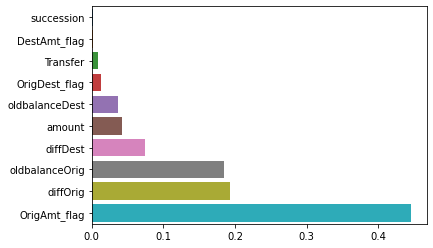

In [69]:
feat_names = xysplit(train)[0].columns
feat_imps = rfc.feature_importances_
sns.barplot(y=feat_names[np.argsort(feat_imps)], x=sorted(feat_imps))

Note: Most Important Features is if the flag of whether the difference in origin balance is equal to the amount of the transaction

## 3 Final Model

In [103]:
df = pd.read_csv('transactions.csv')

In [104]:
df['diffOrig'] = df['newbalanceOrig'] - df['oldbalanceOrig']
df['diffDest'] = df['newbalanceDest'] - df['oldbalanceDest']
df['succession'] = df.groupby(['step', 'nameDest']).cumcount() + 1
df['OrigDest_flag'] = (df['diffOrig'] == -df['diffDest']) * 1
df['OrigAmt_flag'] = (df['diffOrig'] == -df['amount']) * 1
df['DestAmt_flag'] = (df['diffDest'] == df['amount']) * 1

In [105]:
df = df[df['nameDest'].str[0] != 'M']
df = df.loc[df['type'].isin(['CASH_OUT', 'TRANSFER'])]
df = df[df['amount'] > 0]

In [106]:
features, target = xysplit(df)

In [108]:
sm = SMOTE()
features_sm, target_sm = sm.fit_resample(features, target)

In [92]:
df_suc_cnt = df.groupby(['step', 'nameDest']).size()

In [109]:
rfc = RandomForestClassifier(n_jobs=-1)
rfc.fit(features_sm, target_sm)

RandomForestClassifier(n_jobs=-1)

In [112]:
import pickle
with open('model.pickle', 'wb') as f:
    pickle.dump(rfc, f)

In [111]:
import pickle
with open('succession_counter.pickle', 'wb') as f:
    pickle.dump(df_suc_cnt, f)